#  Proyecto de Modelado Predictivo USD/EUR: Sistema Combinado

Este proyecto tiene como objetivo construir una herramienta estratégica capaz de **proyectar el tipo de cambio USD/EUR entre hoy y los próximos 3 años**, integrando variables macroeconómicas, patrones históricos y decisiones operativas.

---

##  Objetivo General

> Desarrollar un **modelo combinado** que utilice tanto variables exógenas (económicas) como series temporales internas, y que genere recomendaciones sobre conversión de divisas para fechas específicas.

---

##  Componentes del Sistema

### 1.  Modelo Macroeconómico
- Algoritmo: `XGBoost`
- Variables: `DXY`, `Inflación USA`, `Tasa Fed`, `USD_EUR_lag1`, etc.
- Proyección: comportamiento USD/EUR basado en indicadores externos

### 2.  Modelo Temporal
- Algoritmo: `Prophet`
- Variable: Histórico mensual de USD/EUR desde 2010
- Proyección: evolución interna del tipo de cambio sin ruido externo

---

##  Integración Inteligente

### 🧬 Fusión estratégica:
- Calcular ambas predicciones para una fecha (`XGBoost + Prophet`)
- Combinar por **promedio ponderado** o **reglas de consenso**
- Generar una **recomendación contextual**: convertir, mantener, cubrir

---

##  Exportación del Modelo

- Guardar ambos modelos (`XGBoost` y `Prophet`) en formato `.pkl` o equivalente
- Integrar en una estructura única que permita:
  - Recibir fecha como input
  - Ejecutar ambos motores
  - Devolver valor proyectado + recomendación + gráfica

---

##  Evaluación y Métricas

### 1. Métricas individuales (ya obtenidas)
- MAE, RMSE, MAPE, R² de XGBoost
- Error porcentual Prophet

### 2. Métricas combinadas
- Promedio de predicciones
- Comparación contra valores reales de test
- Error combinado total (MAPE global)

### 3. Visualizaciones:
- Gráfico comparativo: Real vs XGBoost vs Prophet vs Combinado
- Curvas de residuales
- Barras de error por modelo

---

##  Próximos pasos

1. Crear función `evaluar_fecha_dual(fecha_objetivo)` que combine ambos modelos
2. Calcular métricas del modelo combinado
3. Crear visualización comparativa
4. Guardar estructura completa como modelo exportable
5. Definir estructura mínima para integración en app o sistema externo

---

In [2]:
# Manipulación y análisis
import pandas as pd
import numpy as np

# Visualización 
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn-v0_8-darkgrid")

#  Modelos de aprendizaje 
from xgboost import XGBRegressor
from prophet import Prophet
from sklearn.ensemble import RandomForestRegressor

# Métricas 
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
    r2_score
)

#  Guardado y carga de modelos 
import joblib

#  Configuración general 
import warnings
warnings.filterwarnings("ignore")

#  Fecha 
from datetime import datetime


In [4]:
# Cargar el dataset económico
df = pd.read_csv("dataset_final_economico.csv", parse_dates=["Fecha"])
df.set_index("Fecha", inplace=True)
df.sort_index(inplace=True)
df.head()


,USD_EUR,DXY,Inflación USA,Tasa Fed
Fecha,,,,
2010-02-01,1.392699,79.239998,217.281,0.13
2010-03-01,1.356208,80.660004,217.353,0.16
2010-04-01,1.358400,80.779999,217.403,0.20
2010-06-01,1.223301,86.639999,217.199,0.18
2010-07-01,1.250750,84.720001,217.605,0.18


In [5]:
# Crear rezagos de la variable objetivo
df["USD_EUR_lag1"] = df["USD_EUR"].shift(1)
df["USD_EUR_lag3"] = df["USD_EUR"].shift(3)

# Opcional: rezagos de indicadores relevantes (como DXY)
df["DXY_lag1"] = df["DXY"].shift(1)
df["DXY_lag3"] = df["DXY"].shift(3)

# Eliminar filas con nulos generados por los rezagos
df.dropna(inplace=True)


In [6]:
# Segmentación temporal
df_train = df.loc[:'2023-12']
df_test = df.loc['2024-01':]

# Variables independientes (X) y dependiente (y)
X_train = df_train.drop(columns=["USD_EUR"])
y_train = df_train["USD_EUR"]

X_test = df_test.drop(columns=["USD_EUR"])
y_test = df_test["USD_EUR"]


In [13]:
modelo_prophet = joblib.load("modelo_prophet.pkl")


In [14]:
from xgboost import XGBRegressor

# Entrenamiento del modelo XGBoost
modelo_xgb = XGBRegressor(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

modelo_xgb.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, ...)

In [15]:
# Evaluación rápida sobre conjunto de test
pred_xgb = modelo_xgb.predict(X_test)

mae_xgb = mean_absolute_error(y_test, pred_xgb)
rmse_xgb = mean_squared_error(y_test, pred_xgb)**0.5
mape_xgb = mean_absolute_percentage_error(y_test, pred_xgb)*100
r2_xgb = r2_score(y_test, pred_xgb)

print("Rendimiento XGBoost en conjunto test:")
print(f"MAE  = {mae_xgb:.4f}")
print(f"RMSE = {rmse_xgb:.4f}")
print(f"MAPE = {mape_xgb:.2f}%")
print(f"R²   = {r2_xgb:.4f}")


Rendimiento XGBoost en conjunto test:
MAE  = 0.0118
RMSE = 0.0161
MAPE = 1.07%
R²   = 0.2700


In [16]:
def evaluar_fecha_dual(fecha_objetivo, entrada_macro):
    """
    Predice el tipo de cambio USD/EUR para una fecha específica utilizando:
    - modelo Prophet (temporal)
    - modelo XGBoost (macroeconómico)
    
    Parámetros:
    ----------
    fecha_objetivo : str
        Fecha objetivo en formato 'YYYY-MM-DD'
    entrada_macro : pd.DataFrame
        Un DataFrame con una única fila que contenga las variables exógenas para XGBoost
    
    Retorna:
    --------
    dict con valores clave del análisis
    """
    
    # Verificar que Prophet tiene esa fecha
    prophet_pred = sistema_combinado["forecast_prophet"]
    fila = prophet_pred[prophet_pred["ds"] == fecha_objetivo]
    
    if fila.empty:
        raise ValueError("La fecha objetivo no está disponible en el forecast de Prophet.")
    
    valor_prophet = fila["yhat"].values[0]
    
    # Predicción XGBoost
    valor_xgb = sistema_combinado["xgb"].predict(entrada_macro)[0]
    
    # Promedio combinado
    valor_combinado = (valor_xgb + valor_prophet) / 2
    
    # Métricas
    diferencia = abs(valor_xgb - valor_prophet)
    desviación_pct = 100 * diferencia / valor_combinado
    
    # Recomendación simple
    if desviación_pct < 2.0:
        recomendacion = "Ambos modelos coinciden, se recomienda confianza operativa moderada."
    elif valor_xgb > valor_prophet:
        recomendacion = "XGBoost anticipa impacto externo alcista; considerar refuerzo."
    else:
        recomendacion = "Prophet indica subida interna; verificar señales exógenas antes de operar."
    
    # Salida
    resultado = {
        "Fecha": fecha_objetivo,
        "Predicción XGBoost": round(valor_xgb, 4),
        "Predicción Prophet": round(valor_prophet, 4),
        "Promedio Combinado": round(valor_combinado, 4),
        "Desviación (%)": round(desviación_pct, 2),
        "Recomendación": recomendacion
    }
    
    return resultado


In [18]:
# Generar el forecast de Prophet si no existe
forecast = modelo_prophet.predict(modelo_prophet.make_future_dataframe(periods=36, freq='MS'))

# Crear la estructura combinada
sistema_combinado = {
    "xgb": modelo_xgb,
    "prophet": modelo_prophet,
    "forecast_prophet": forecast
}

# Guardar con joblib
import joblib
joblib.dump(sistema_combinado, "sistema_usdeur.pkl")

print("✅ Sistema combinado guardado como 'sistema_usdeur.pkl'")


✅ Sistema combinado guardado como 'sistema_usdeur.pkl'


In [19]:
# Extraer fechas disponibles en el test
fechas_test = y_test.index.strftime("%Y-%m-%d")

# Listas para almacenar las predicciones
pred_prophet = []
pred_xgb = []
pred_promedio = []
real = []

for fecha in fechas_test:
    # Predicción Prophet
    fila = forecast[forecast["ds"] == fecha]
    if fila.empty:
        continue
    valor_p = fila["yhat"].values[0]
    
    # Predicción XGBoost
    entrada = X_test.loc[fecha].to_frame().T  # Formato DataFrame
    valor_x = modelo_xgb.predict(entrada)[0]
    
    # Promedio combinado
    valor_m = (valor_p + valor_x) / 2
    
    # Valor real
    valor_real = y_test.loc[fecha]
    
    # Almacenar
    pred_prophet.append(valor_p)
    pred_xgb.append(valor_x)
    pred_promedio.append(valor_m)
    real.append(valor_real)

# Convertir en arrays
real = np.array(real)
pred_prophet = np.array(pred_prophet)
pred_xgb = np.array(pred_xgb)
pred_promedio = np.array(pred_promedio)


In [20]:
# Crear tabla de errores
def calcular_metricas(y_true, y_pred):
    return {
        "MAE": round(mean_absolute_error(y_true, y_pred), 4),
        "RMSE": round(mean_squared_error(y_true, y_pred) ** 0.5, 4),
        "MAPE (%)": round(mean_absolute_percentage_error(y_true, y_pred) * 100, 2),
        "R²": round(r2_score(y_true, y_pred), 4)
    }

metricas = pd.DataFrame({
    "XGBoost": calcular_metricas(real, pred_xgb),
    "Prophet": calcular_metricas(real, pred_prophet),
    "Combinado": calcular_metricas(real, pred_promedio)
})

metricas


,XGBoost,Prophet,Combinado
MAE,0.0118,0.0167,0.0103
RMSE,0.0161,0.0211,0.0161
MAPE (%),1.0700,1.5300,0.9300
R²,0.2700,-0.2534,0.2768


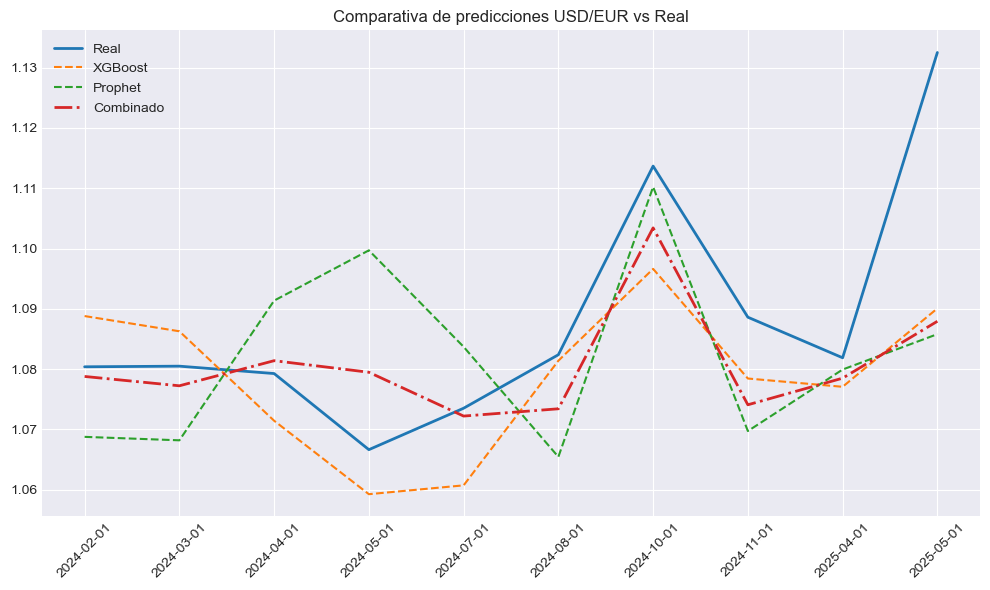

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(fechas_test[:len(real)], real, label="Real", linewidth=2)
plt.plot(fechas_test[:len(real)], pred_xgb, label="XGBoost", linestyle="--")
plt.plot(fechas_test[:len(real)], pred_prophet, label="Prophet", linestyle="--")
plt.plot(fechas_test[:len(real)], pred_promedio, label="Combinado", linestyle="-.", linewidth=2)
plt.legend()
plt.xticks(rotation=45)
plt.title("Comparativa de predicciones USD/EUR vs Real")
plt.tight_layout()
plt.show()
